# SYSID - Trabalho (ML - SISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [143]:
# Pacotes padrao
import os
import pickle
import copy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, fft, fftpack
from datetime import datetime


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Scores

#Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Disabling warnings

#Definindo random_state
rs = 85

In [144]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from sklearn_sid.regressors.sklearn import SYSIDRegressor

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [145]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/Onedrive/Mestrado/gits/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


In [146]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


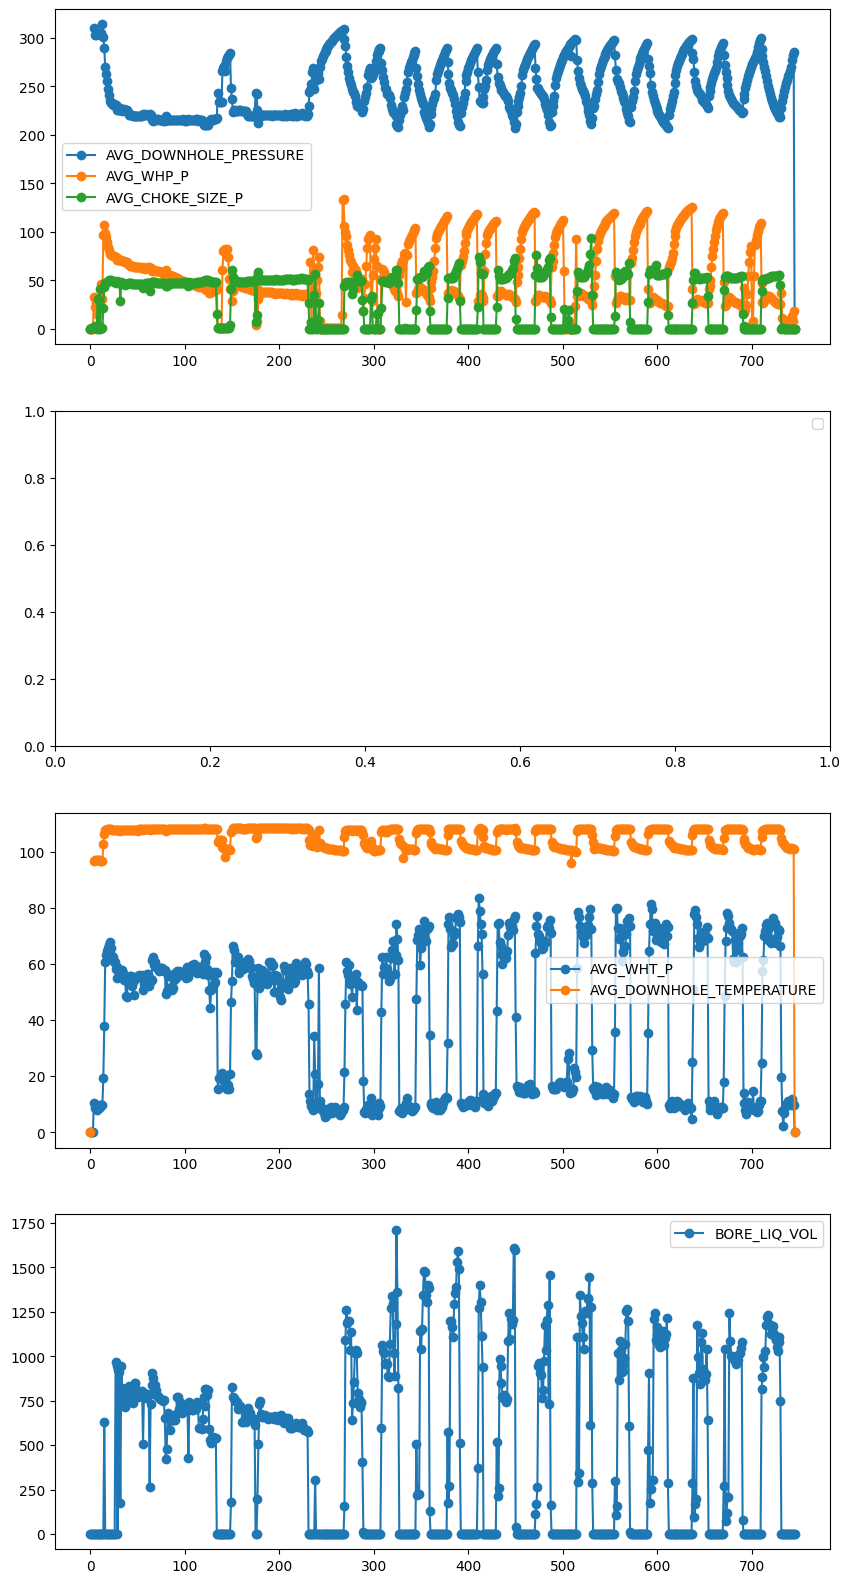

In [147]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [148]:
data_case = data_case.iloc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [149]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [150]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [151]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 5) (718, 5)


### 1.3 - Removendo a escala 

In [173]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [186]:
decomp = seasonal_decompose(X_te, period=15, extrapolate_trend='freq', two_sided=False)

In [185]:
decomp.trend

array([[ 0.26214423,  0.57669339,  0.60049352,  0.6284108 ,  0.93641692],
       [ 0.25609211,  0.57266224,  0.59989485,  0.629029  ,  0.93683405],
       [ 0.25003999,  0.56863109,  0.59929618,  0.62964721,  0.93725117],
       ...,
       [ 0.42808588,  0.09223387,  0.08831217,  0.15916102,  0.55272718],
       [ 0.47139998,  0.08871024,  0.04025211,  0.10585197,  0.51604625],
       [ 0.32878804,  0.07593112,  0.00150803,  0.0489329 , -0.05345055]])

### 1.4 - Decompondo a série

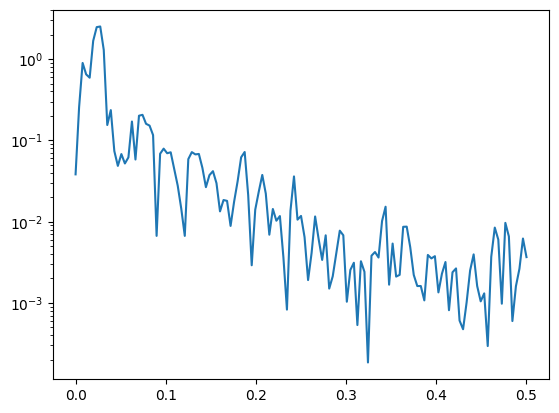

In [125]:
from scipy.signal import periodogram, welch, stft, istft

f, Pxx_den = welch(y_tr.ravel(), 1.0)
plt.semilogy(f, Pxx_den)

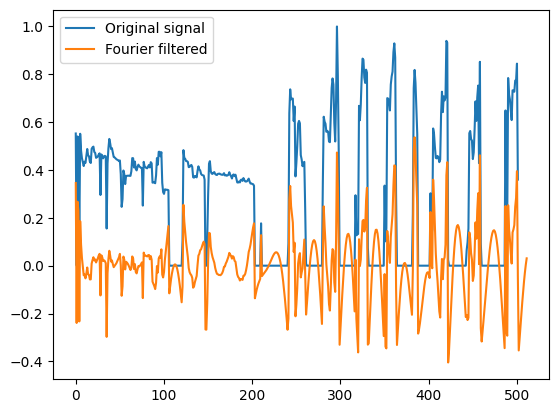

In [134]:
# Define the time range and signal
f = 1.0
t = np.linspace(0, len(y_tr), len(y_tr), endpoint=False)
#y_tr = np.sin(t/50) + np.sin(t/25)
freq, t, ft = stft(y_tr.ravel(), nperseg=256)
#freq = fft.fftfreq(y_tr.size, d=1/y_tr.size)

ft_copy = ft.copy()
ft_copy[:10,:] = 0
#ft_copy[:10,2:] = 0
#ft_copy[np.abs(freq)>=100] = 0
#ft_copy[np.abs(freq)<=10] = 0
y_tr_low = istft(ft_copy, nperseg=256)
plt.plot(y_tr, label='Original signal')
plt.plot(y_tr_low[0], y_tr_low[1], label='Fourier filtered')
plt.legend()
plt.show()

In [127]:
t.shape

(5,)

In [128]:
y_tr_low[0].shape

(512,)

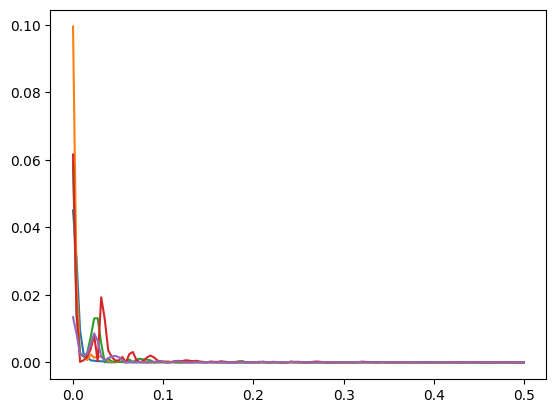

In [129]:
plot = plt.plot(freq, np.abs(ft)**2)

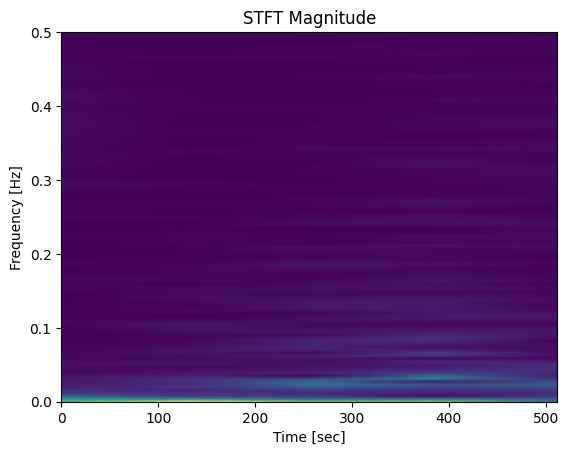

In [130]:
plt.pcolormesh(t, freq, np.abs(ft), vmin=0, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

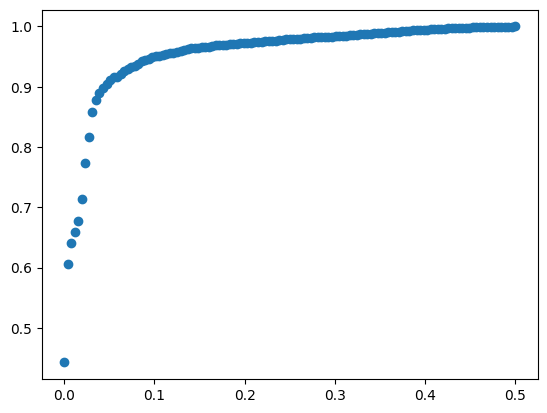

In [131]:
avg_cumsum = np.average(np.cumsum(np.abs(ft)**2, axis=0)/np.cumsum(np.abs(ft)**2, axis=0)[-1,:].reshape(1,-1), axis=1)
plt.plot(freq, avg_cumsum, 'o')

In [136]:
freq[10]

0.0390625